In [48]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.linear_model import LogisticRegression 
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import seaborn as sns
import warnings
import statsmodels.api as sm

warnings.filterwarnings('ignore')
from myworkspaceutils.datasets.micro_rna import MiRNA_GSE120584_Binary

In [2]:
data_dir = f"{Path.cwd().parent}/mirna_data"
mirna = MiRNA_GSE120584_Binary(data_dir)

In [3]:
meta_data_ad, series_mtrx_ad = mirna.load_data(cohort="discovery", label="ad")
meta_data_vad, series_mtrx_vad = mirna.load_data(cohort="discovery", label="vad")
meta_data_dlb, series_mtrx_dlb = mirna.load_data(cohort="discovery", label="dlb")

In [4]:
meta_data_ad.head()

,sample_id,age,sex,apoe4,label
0,GSM3403761,79,0,0,1
1,GSM3403762,77,0,1,1
2,GSM3403763,76,0,0,1
3,GSM3403764,88,0,1,1
4,GSM3403765,74,1,0,1


In [5]:
series_mtrx_ad.shape

(2547, 656)

In [6]:
def calculate_z_values(series_mtrx, meta_data): 
    y = meta_data[['sample_id','label']].set_index('sample_id')
    X_mirna = series_mtrx.set_index("ID_REF").T
    covariates = meta_data[['sample_id','age', 'sex', 'apoe4']]
    
    z_values = {}
    
    for mirna in tqdm(X_mirna.columns):
        X = pd.concat([X_mirna[[mirna]], covariates.set_index('sample_id')], axis=1)  
        model = LogisticRegression(penalty=None, max_iter=1000)
        model.fit(X, y) 

        X_sm = sm.add_constant(X)
        logit_model = sm.Logit(y, X_sm)
        result = logit_model.fit(disp=0)
        
        coef = result.params[1]
        se = result.bse[1]
        z = coef / se
        
        z_values[mirna] = z
    
    return pd.Series(z_values)


# Z-Values

In [7]:
def plot_histogram(z_values, title="'DISCOVERY Cohort: miRNA Association Strength'"):
    plt.figure(figsize=(10, 6))

    # Histogram
    plt.hist(z_values, bins=50, alpha=0.7, edgecolor='black', density=True)

    # thresholds
    thresholds = [2.0, 3.0, 4.0, 4.5, 5.0]
    colors = ['orange', 'yellow', 'green', 'red', 'purple']

    for T, color in zip(thresholds, colors):
        plt.axvline(x=T, color=color, linestyle='--', alpha=0.7, 
                label=f'T={T} ({ (np.abs(z_values) > T).sum()} miRNAs)')
        plt.axvline(x=-T, color=color, linestyle='--', alpha=0.7)

    plt.axvline(x=0, color='black', linewidth=1)
    plt.xlabel('z-value')
    plt.ylabel('Density')
    plt.title(title)
    plt.legend(loc='upper left', fontsize=9)
    plt.show()

In [8]:
def get_z_value_summary(z_values):
    summary_data = []
    for T in [2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]:
        n_above = (z_values > T).sum()
        n_below = (z_values < -T).sum()
        n_total = n_above + n_below
        
        summary_data.append({
            'Threshold (T)': T,
            'Total miRNAs': n_total,
            'Upregulated': n_above,
            'Downregulated': n_below,
            'Percentage': f"{n_total/2547*100:.1f}%"
        })

    # to df
    summary_df = pd.DataFrame(summary_data)
    return summary_df

## AD

In [9]:
z_values_ad = calculate_z_values(series_mtrx_ad, meta_data_ad)

# Check results
print(f"Calculated z-values for {len(z_values_ad)} miRNAs")
print("\nZ-value statistics:")
print(f"Mean: {z_values_ad.mean():.3f}")
print(f"Std: {z_values_ad.std():.3f}")
print(f"Min: {z_values_ad.min():.3f}")
print(f"Max: {z_values_ad.max():.3f}")
print(f"Number with |z| > 2: {(np.abs(z_values_ad) > 2).sum()}")

100%|██████████| 2547/2547 [00:28<00:00, 89.79it/s] 

Calculated z-values for 2547 miRNAs

Z-value statistics:
Mean: 0.849
Std: 1.689
Min: -6.272
Max: 6.527
Number with |z| > 2: 694


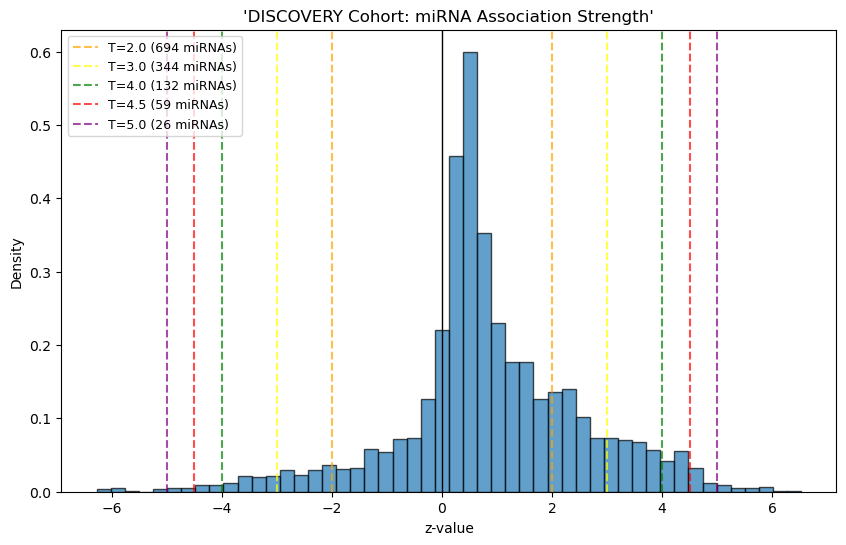

,Threshold (T),Total miRNAs,Upregulated,Downregulated,Percentage
0,2.0,694,544,150,27.2%
1,2.5,486,380,106,19.1%
2,3.0,344,272,72,13.5%
3,3.5,229,183,46,9.0%
4,4.0,132,108,24,5.2%
5,4.5,59,45,14,2.3%
6,5.0,26,18,8,1.0%


In [10]:
plot_histogram(z_values_ad)
  
get_z_value_summary(z_values_ad)

In [22]:
z_values_ad.to_csv(f'{data_dir}/z_values_ad_discovery.csv')

## VAD

In [12]:
z_values_vad = calculate_z_values(series_mtrx_vad, meta_data_vad)

100%|██████████| 2547/2547 [00:26<00:00, 96.85it/s] 


In [13]:
# results
print(f"Calculated z-values for {len(z_values_vad)} miRNAs")
print("\nZ-value statistics:")
print(f"Mean: {z_values_vad.mean():.3f}")
print(f"Std: {z_values_vad.std():.3f}")
print(f"Min: {z_values_vad.min():.3f}")
print(f"Max: {z_values_vad.max():.3f}")
print(f"Number with |z| > 2: {(np.abs(z_values_vad) > 2).sum()}")

Calculated z-values for 2547 miRNAs

Z-value statistics:
Mean: 1.745
Std: 1.670
Min: -4.648
Max: 5.911
Number with |z| > 2: 1056


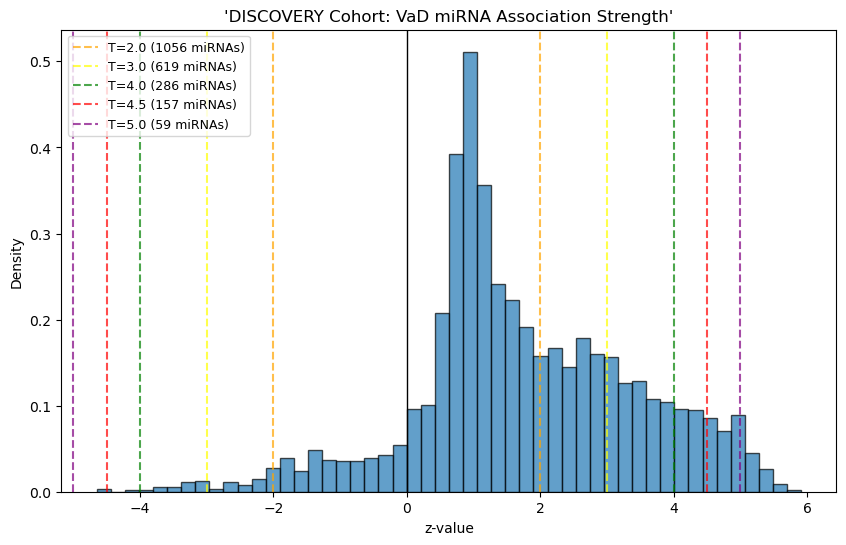

,Threshold (T),Total miRNAs,Upregulated,Downregulated,Percentage
0,2.0,1056,1004,52,41.5%
1,2.5,845,814,31,33.2%
2,3.0,619,598,21,24.3%
3,3.5,428,421,7,16.8%
4,4.0,286,283,3,11.2%
5,4.5,157,156,1,6.2%
6,5.0,59,59,0,2.3%


In [14]:
plot_histogram(z_values_vad, title="'DISCOVERY Cohort: VaD miRNA Association Strength'")
  
get_z_value_summary(z_values_vad)



In [23]:
z_values_vad.to_csv(f'{data_dir}/z_values_vad_discovery.csv')

# DLB

In [16]:
z_values_dlb = calculate_z_values(series_mtrx_dlb, meta_data_dlb)
print(f"Calculated z-values for {len(z_values_dlb)} miRNAs")
print("\nZ-value statistics:")
print(f"Mean: {z_values_dlb.mean():.3f}")
print(f"Std: {z_values_dlb.std():.3f}")
print(f"Min: {z_values_dlb.min():.3f}")
print(f"Max: {z_values_dlb.max():.3f}")
print(f"Number with |z| > 2: {(np.abs(z_values_dlb) > 2).sum()}")

100%|██████████| 2547/2547 [00:23<00:00, 106.77it/s]

Calculated z-values for 2547 miRNAs

Z-value statistics:
Mean: 0.716
Std: 1.715
Min: -5.259
Max: 6.102
Number with |z| > 2: 686


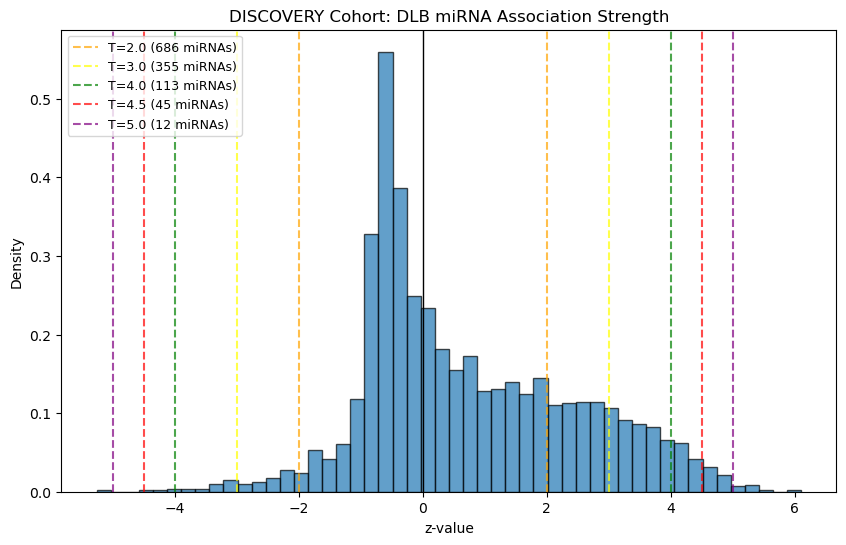

,Threshold (T),Total miRNAs,Upregulated,Downregulated,Percentage
0,2.0,686,618,68,26.9%
1,2.5,510,471,39,20.0%
2,3.0,355,331,24,13.9%
3,3.5,229,221,8,9.0%
4,4.0,113,110,3,4.4%
5,4.5,45,43,2,1.8%
6,5.0,12,11,1,0.5%


In [17]:
plot_histogram(z_values_dlb, title="DISCOVERY Cohort: DLB miRNA Association Strength")
 

get_z_value_summary(z_values_dlb) 

In [24]:
z_values_dlb.to_csv(f'{data_dir}/z_values_dlb_discovery.csv')

In [28]:
z_values_ad.index

Index(['MIMAT0000062', 'MIMAT0000063', 'MIMAT0000064', 'MIMAT0000065',
       'MIMAT0000066', 'MIMAT0000067', 'MIMAT0000068', 'MIMAT0000069',
       'MIMAT0000070', 'MIMAT0000071',
       ...
       'MIMAT0031892', 'MIMAT0031893', 'MIMAT0032026', 'MIMAT0032029',
       'MIMAT0032110', 'MIMAT0032116', 'MIMAT0033692', 'MIMAT0035542',
       'MIMAT0035703', 'MIMAT0035704'],
      dtype='object', length=2547)

In [29]:
print("are they in same order?")
print(f"AD and VaD order: {z_values_ad.index.equals(z_values_vad.index)}")
print(f"AD and DLB order: {z_values_ad.index.equals(z_values_dlb.index)}")

are they in same order?
AD and VaD order: True
AD and DLB order: True


In [30]:
print("NaN?")
print(f"AD NaN count: {z_values_ad.isna().sum()}")
print(f"VaD NaN count: {z_values_vad.isna().sum()}")
print(f"DLB NaN count: {z_values_dlb.isna().sum()}")

NaN?
AD NaN count: 0
VaD NaN count: 0
DLB NaN count: 0


In [32]:
z_values_ad.values

array([ 0.2859715 , -0.11886931, -0.11895382, ..., -1.48308059,
        0.72833433,  0.32689497])

In [33]:

z_df = pd.DataFrame()
z_df['miRNA'] = z_values_ad.index
z_df['ad'] = z_values_ad.values
z_df['vad'] = z_values_vad.values
z_df['dlb'] = z_values_dlb.values
z_df.head()

,miRNA,ad,vad,dlb
0,MIMAT0000062,0.285971,1.791096,-1.164296
1,MIMAT0000063,-0.118869,1.941880,-0.368173
2,MIMAT0000064,-0.118954,1.691423,-0.451337
3,MIMAT0000065,0.295268,2.108311,-0.345707
4,MIMAT0000066,0.308849,2.265358,-0.657418


In [35]:
z_df.to_csv(f'{data_dir}/z_values_discovery.csv', index=False)

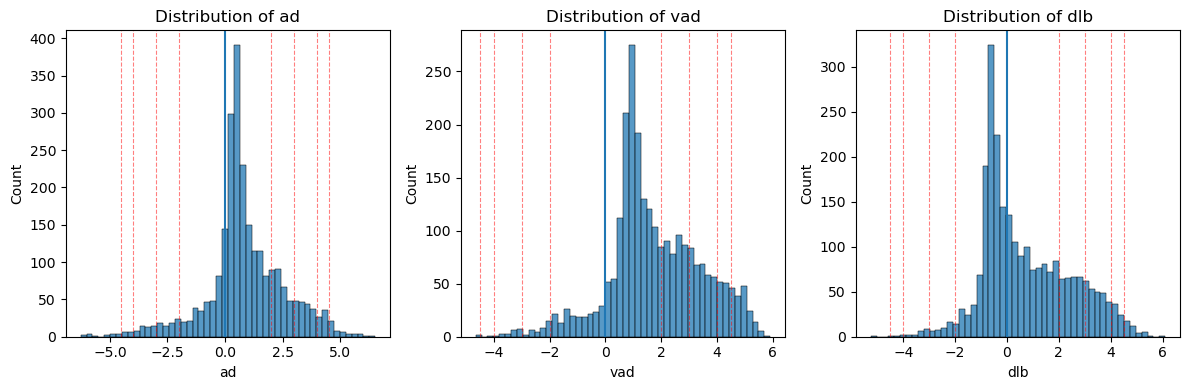

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

columns = ['ad', 'vad', 'dlb']
for i, (column, ax) in enumerate(zip(columns, axes)):
    # 0 lines
    ax.axvline(x=0)

    sns.histplot(data=z_df, x=column, bins=50, ax=ax)
    ax.set_title(f'Distribution of {column}')

    # threshold lines
    for T in [2.0, 3.0, 4.0, 4.5]:
        ax.axvline(x=T, color='red', linestyle='--', alpha=0.5, linewidth=0.8)
        ax.axvline(x=-T, color='red', linestyle='--', alpha=0.5, linewidth=0.8)

plt.tight_layout()
plt.show()

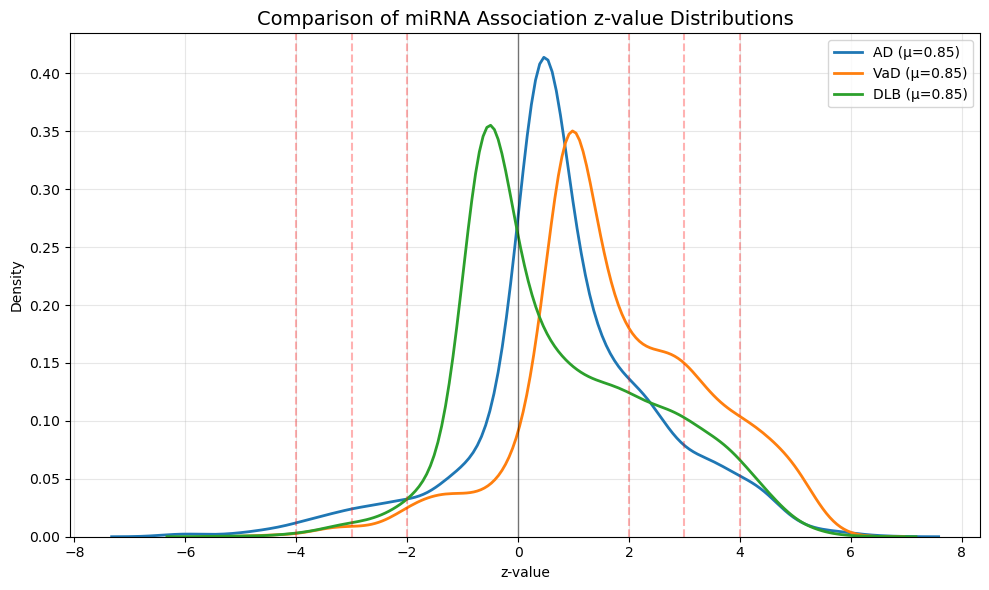

In [40]:
plt.figure(figsize=(10, 6))

# Create density plots
sns.kdeplot(z_df['ad'], label=f"AD (μ={z_df['ad'].mean():.2f})", linewidth=2)
sns.kdeplot(z_df['vad'], label=f"VaD (μ={z_df['ad'].mean():.2f})", linewidth=2)
sns.kdeplot(z_df['dlb'], label=f"DLB (μ={z_df['ad'].mean():.2f})", linewidth=2)

# Add thresholds
for T in [2.0, 3.0, 4.0]:
    plt.axvline(x=T, color='red', linestyle='--', alpha=0.3)
    plt.axvline(x=-T, color='red', linestyle='--', alpha=0.3)

plt.axvline(x=0, color='black', linewidth=1, alpha=0.5)
plt.xlabel('z-value')
plt.ylabel('Density')
plt.title('Comparison of miRNA Association z-value Distributions', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [41]:

def get_top_mirnas(z_series, n=10, name=""): 
    top_abs = z_series.abs().sort_values(ascending=False).head(n)
    top_df = pd.DataFrame({
        'MIMAT_ID': z_df['miRNA'][top_abs.index],
        'z-value': z_series[top_abs.index],
        '|z|': top_abs.values
    })
    return top_df

top_ad = get_top_mirnas(z_df['ad'], n=10, name="AD")
top_vad = get_top_mirnas(z_df['vad'], n=10, name="VaD")
top_dlb = get_top_mirnas(z_df['dlb'], n=10, name="DLB")

# Find common miRNAs in top lists
top_20_ad = set(z_df['ad'].abs().sort_values(ascending=False).head(20).index)
top_20_vad = set(z_df['vad'].abs().sort_values(ascending=False).head(20).index)
top_20_dlb = set(z_df['dlb'].abs().sort_values(ascending=False).head(20).index)

print(f"\nOverlap in top 20 miRNAs:")
print(f"AD ∩ VaD: {len(top_20_ad & top_20_vad)} miRNAs")
print(f"AD ∩ DLB: {len(top_20_ad & top_20_dlb)} miRNAs")
print(f"VaD ∩ DLB: {len(top_20_vad & top_20_dlb)} miRNAs")
print(f"All three: {len(top_20_ad & top_20_vad & top_20_dlb)} miRNAs")


Overlap in top 20 miRNAs:
AD ∩ VaD: 4 miRNAs
AD ∩ DLB: 3 miRNAs
VaD ∩ DLB: 4 miRNAs
All three: 1 miRNAs


In [42]:
top_ad

,MIMAT_ID,z-value,|z|
949,MIMAT0015057,6.526507,6.526507
929,MIMAT0015036,-6.271875,6.271875
2374,MIMAT0027650,-6.248515,6.248515
2147,MIMAT0027423,6.023540,6.023540
2064,MIMAT0026916,5.992915,5.992915
955,MIMAT0015064,-5.970679,5.970679
1017,MIMAT0016878,-5.948595,5.948595
2192,MIMAT0027468,-5.892122,5.892122
815,MIMAT0007401,5.862922,5.862922
1092,MIMAT0018004,5.847596,5.847596


In [43]:
top_vad

,MIMAT_ID,z-value,|z|
71,MIMAT0000268,5.911480,5.911480
2193,MIMAT0027469,5.658633,5.658633
1864,MIMAT0022731,5.651488,5.651488
2179,MIMAT0027455,5.645672,5.645672
2277,MIMAT0027553,5.506638,5.506638
2147,MIMAT0027423,5.491996,5.491996
1060,MIMAT0016921,5.482927,5.482927
228,MIMAT0002176,5.444197,5.444197
694,MIMAT0005584,5.434936,5.434936
1092,MIMAT0018004,5.429824,5.429824


In [44]:
top_dlb

,MIMAT_ID,z-value,|z|
1864,MIMAT0022731,6.101559,6.101559
1014,MIMAT0016875,5.423277,5.423277
1027,MIMAT0016888,5.414929,5.414929
809,MIMAT0006790,5.409276,5.409276
1982,MIMAT0025845,5.356845,5.356845
442,MIMAT0003881,5.297168,5.297168
2111,MIMAT0027387,-5.259234,5.259234
1553,MIMAT0019849,5.240593,5.240593
1924,MIMAT0023713,5.159449,5.159449
867,MIMAT0013518,5.140980,5.140980


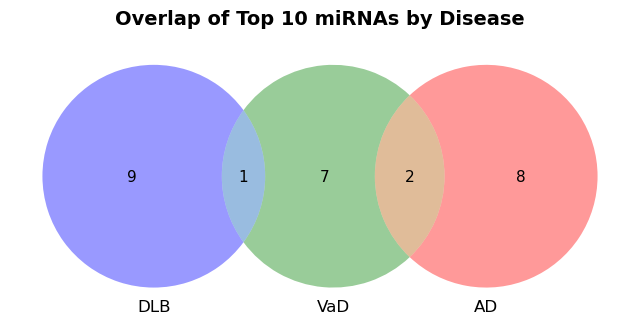

Overlap statistics for top 10 miRNAs:
AD ∩ VaD: 2 miRNAs
AD ∩ DLB: 0 miRNAs
VaD ∩ DLB: 1 miRNAs
All three: 0 miRNAs
Unique to AD: 8 miRNAs
Unique to VaD: 7 miRNAs
Unique to DLB: 9 miRNAs


In [ ]:


def plot_venn_diagram(top_ad, top_vad, top_dlb, n=10): 
    set_ad = set(top_ad.head(n).index)
    set_vad = set(top_vad.head(n).index)
    set_dlb = set(top_dlb.head(n).index) 
    plt.figure(figsize=(8, 8))
    venn = venn3([set_ad, set_vad, set_dlb], 
                ('AD', 'VaD', 'DLB'))
    
    # Customize
    for text in venn.set_labels:
        text.set_fontsize(12)
    for text in venn.subset_labels:
        if text:  # Not all subsets have labels
            text.set_fontsize(11)
    
    plt.title(f'Overlap of Top {n} miRNAs by Disease', fontsize=14, fontweight='bold')
    plt.show()
    
    # Print statistics
    print(f"Overlap statistics for top {n} miRNAs:")
    print(f"AD ∩ VaD: {len(set_ad & set_vad)} miRNAs")
    print(f"AD ∩ DLB: {len(set_ad & set_dlb)} miRNAs")
    print(f"VaD ∩ DLB: {len(set_vad & set_dlb)} miRNAs")
    print(f"All three: {len(set_ad & set_vad & set_dlb)} miRNAs")
    print(f"Unique to AD: {len(set_ad - set_vad - set_dlb)} miRNAs")
    print(f"Unique to VaD: {len(set_vad - set_ad - set_dlb)} miRNAs")
    print(f"Unique to DLB: {len(set_dlb - set_ad - set_vad)} miRNAs")

# Usage
plot_venn_diagram(top_ad, top_vad, top_dlb, n=10)

In [47]:
def check_overlap_at_different_levels(z_ad, z_vad, z_dlb, levels=[10, 20, 50, 100]):  
    results = []
    for n in levels:
        ad_top = set(z_ad.abs().sort_values(ascending=False).head(n).index)
        vad_top = set(z_vad.abs().sort_values(ascending=False).head(n).index)
        dlb_top = set(z_dlb.abs().sort_values(ascending=False).head(n).index)
        
        results.append({
            'Top n': n,
            'AD∩VaD': len(ad_top & vad_top),
            'AD∩DLB': len(ad_top & dlb_top),
            'VaD∩DLB': len(vad_top & dlb_top),
            'All three': len(ad_top & vad_top & dlb_top)
        })
    
    return pd.DataFrame(results)

# Run this
overlap_df = check_overlap_at_different_levels(z_df['ad'], z_df['vad'], z_df['dlb'])
overlap_df

,Top n,AD∩VaD,AD∩DLB,VaD∩DLB,All three
0,10,2,0,1,0
1,20,4,3,4,1
2,50,15,14,15,8
3,100,44,37,47,29


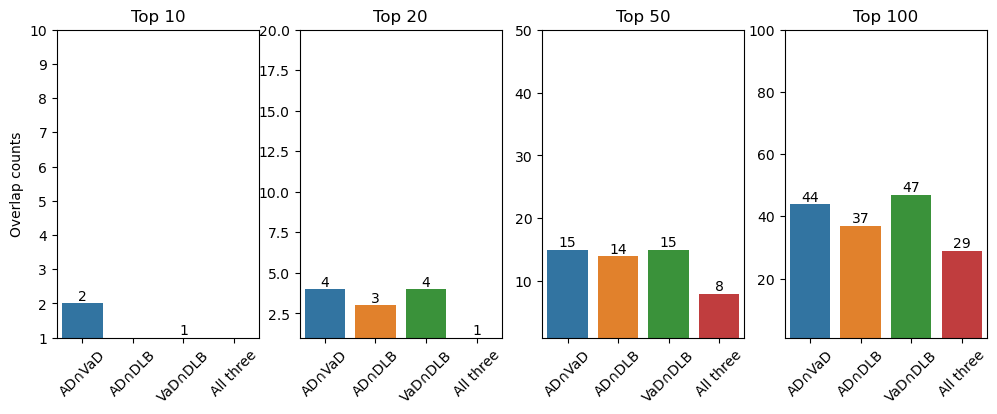

In [105]:
fig, axes = plt.subplots(1, 4, figsize=(12,4))
for i in range(len(overlap_df)):
    bar_data = overlap_df.iloc[i:i+1,1:]
    sns.barplot(data=bar_data, ax=axes[i])
    axes[i].tick_params(axis='x', labelrotation=45)
    axes[i].set_title(f"Top {overlap_df.loc[i]['Top n']}")

    for idx in range(len(bar_data.columns)):
        axes[i].bar_label(axes[i].containers[idx])

    axes[0].set_ylabel("Overlap counts")
    axes[i].set_ylim(1, overlap_df.loc[i]['Top n'])
